## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv
from scipy.spatial.distance import jensenshannon as JS

## Setting up the cluster

In [2]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-07-02 19:24:18,413 - distributed.deploy.ssh - INFO - 2023-07-02 19:24:18,411 - distributed.scheduler - INFO - State start
2023-07-02 19:24:18,417 - distributed.deploy.ssh - INFO - 2023-07-02 19:24:18,413 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_4njosz5', purging
2023-07-02 19:24:18,418 - distributed.deploy.ssh - INFO - 2023-07-02 19:24:18,414 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-aqcbp7jl', purging
2023-07-02 19:24:18,419 - distributed.deploy.ssh - INFO - 2023-07-02 19:24:18,414 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j3rbnsky', purging
2023-07-02 19:24:18,420 - distributed.deploy.ssh - INFO - 2023-07-02 19:24:18,415 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-sqwvx7om', purging
2023-07-02 19:24:18,423 - distributed.deploy.ssh - INFO - 2023-07

In [3]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| tornado | 6.3.2  | 6.3.2     | 6.2     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [4]:
client

<Client: 'tcp://10.67.22.140:8786' processes=16 threads=16, memory=31.03 GiB>

## Data

## Discretizing and introducing labels

# Reading from disk 

In [5]:
n_bins = 100
bhbh_train = dd.read_parquet('/home/ubuntu/train_chirp/*')
bhbh_test = dd.read_parquet('/home/ubuntu/test_chirp/*')

In [6]:
test = bhbh_train['label'].values.compute()
values, counts = np.unique(test, return_counts=True)
for v, c in zip(values, counts):
    print(v,c)

0.0 44546
1.0 113338
2.0 198953
3.0 204538
4.0 180979
5.0 134151
6.0 129761
7.0 128003
8.0 112414
9.0 96466
10.0 88760
11.0 82680
12.0 86031
13.0 87426
14.0 89067
15.0 88396
16.0 91087
17.0 98723
18.0 95738
19.0 89984
20.0 87024
21.0 87166
22.0 89339
23.0 88935
24.0 90598
25.0 84349
26.0 83518
27.0 88906
28.0 83007
29.0 73910
30.0 67641
31.0 63408
32.0 63403
33.0 72261
34.0 88682
35.0 77433
36.0 67081
37.0 63565
38.0 62220
39.0 61213
40.0 61148
41.0 62006
42.0 67463
43.0 68192
44.0 67315
45.0 66214
46.0 66585
47.0 64401
48.0 63671
49.0 62810
50.0 60967
51.0 58329
52.0 57390
53.0 55216
54.0 54013
55.0 51996
56.0 50592
57.0 47479
58.0 44603
59.0 41359
60.0 37115
61.0 32374
62.0 28440
63.0 24628
64.0 22056
65.0 19874
66.0 17718
67.0 16526
68.0 15215
69.0 13645
70.0 12465
71.0 11107
72.0 9808
73.0 8464
74.0 7321
75.0 6293
76.0 5705
77.0 4620
78.0 3802
79.0 3404
80.0 2599
81.0 2215
82.0 1613
83.0 1378
84.0 980
85.0 641
86.0 425
87.0 333
88.0 270
89.0 242
90.0 234
91.0 185
92.0 176
93.0 102


## Sample weigths

In [7]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

## Rename of useful columns

In [8]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [9]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

## Saving and loading the trained model

In [10]:
bst = xgb.Booster()
bst.load_model('bst_Mass_Chirp_0_400.json')

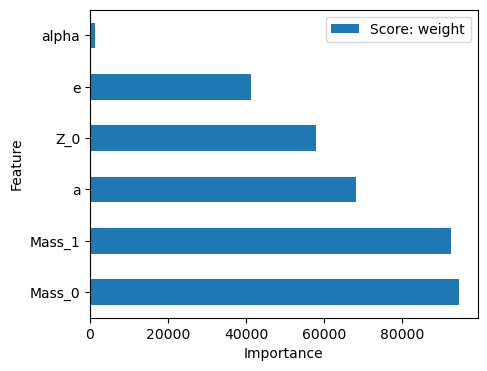

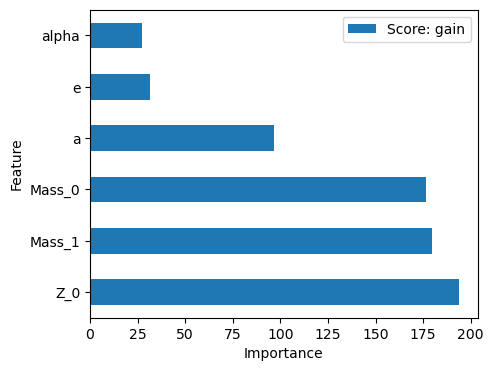

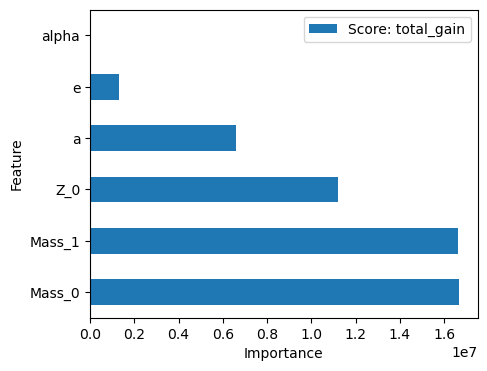

In [11]:
importances=['weight', 'gain', 'total_gain']
for im in importances:
    feature_important = bst.get_score(importance_type=im)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["Score: "+im]).sort_values(by = "Score: "+im, ascending=False)
    data.plot(kind='barh', figsize = (5,4)) ## plot top 40 features
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig('../Figures/lcp/importance_Chirp_Mass_yeskicks_'+im+'.png', bbox_inches='tight')

## Prediction on test

In [12]:
## distributions of the probability of each class for each record

output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

## Predicition of the label with Maximum estimation

predicted_label = output_test.idxmax(axis=1).persist()

## Computing the true labels and the predicted

Y_test = label_test.values.compute()

Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

In [13]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000)
                                )
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


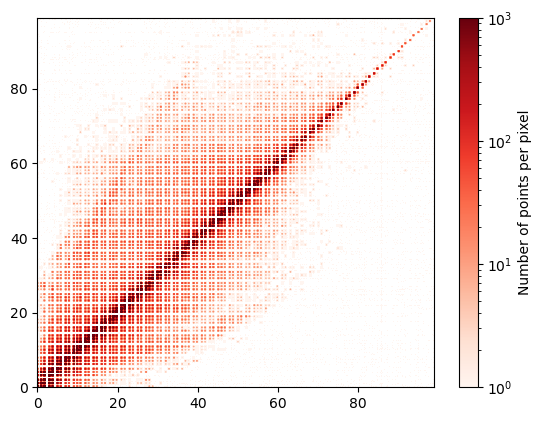

In [14]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

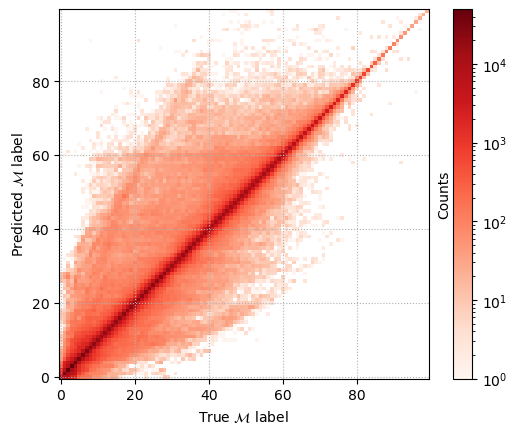

In [15]:
cm=confusion_matrix(Y_test, Y_predicted)
fig = plt.figure()
ax = fig.add_subplot(111)
pp=ax.matshow(cm.T, norm=colors.LogNorm(vmin=1, vmax=cm.max()), cmap='Reds', origin='lower')
cbar=fig.colorbar(pp)
cbar.ax.get_yaxis().labelpad = -50
cbar.ax.set_ylabel('Counts', rotation=90)
plt.grid(linestyle='dotted')
plt.gca().xaxis.tick_bottom()
plt.xlabel(r'True $\mathcal{M}$ label')
plt.ylabel(r'Predicted $\mathcal{M}$ label')
plt.savefig('../Figures/lcp/confusion_matrix_labels_Chirp_Mass_yeskicks.png', bbox_inches='tight')

## Histogram of the q distribution

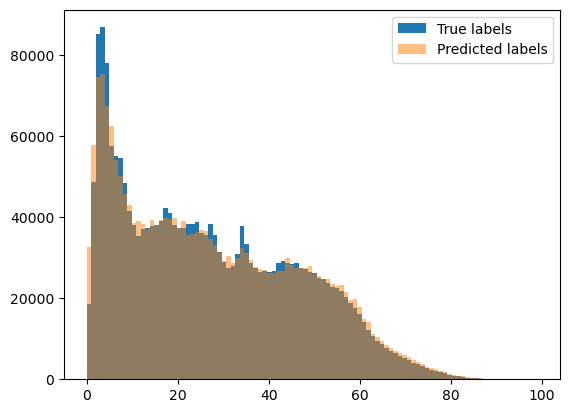

In [16]:
plt.hist(Y_test, bins=n_bins, label = 'True labels')
plt.hist(Y_predicted, bins=n_bins, alpha=0.5, label='Predicted labels')
plt.legend()

# Metrics

In [17]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

## Kulback-Leibler metrics

In [18]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

In [19]:
KL_div

0.00490644259461504

## JS (limited between 0 and 1 when base=2)

In [20]:
JS_div = JS(counts_test, counts_predicted, base=2)

In [21]:
JS_div

0.04130877884786667

## Histogram of the Chirp mass distribution with metrics

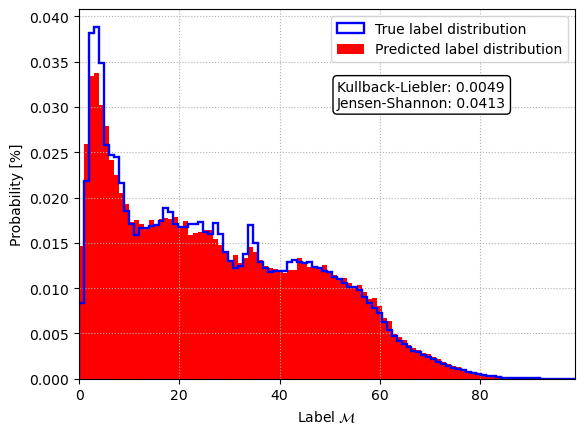

In [22]:
plt.hist(Y_test, bins=n_bins, label = 'True label distribution', histtype='step', density=True, color='blue',  linewidth=1.7)#, linestyle='dashed')
plt.hist(Y_predicted, bins=n_bins, label='Predicted label distribution', density=True, color='red')
plt.xlim(0,99)
plt.grid(linestyle='dotted')
plt.xlabel(r'Label $\mathcal{M}$')
plt.ylabel('Probability [%]')
plt.text(51.5, 0.033, "Kullback-Liebler: {:.4f}\nJensen-Shannon: {:.4f}".format(KL_div, JS_div),
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',
                   )
         )
plt.legend()
plt.savefig('../Figures/lcp/hist_Chirp_Mass_yeskicks.png', bbox_inches='tight')

## Histogram of difference of true and prediction

In [23]:
#95% interval 
diff = (Y_predicted-Y_test)
lower=np.quantile(diff, q=0.025) 
upper= np.quantile(diff, q=0.975)
print(lower, upper)

-5.0 11.0


Text(0.5, 0, '$|y_{true}-y_{predicted}|$')

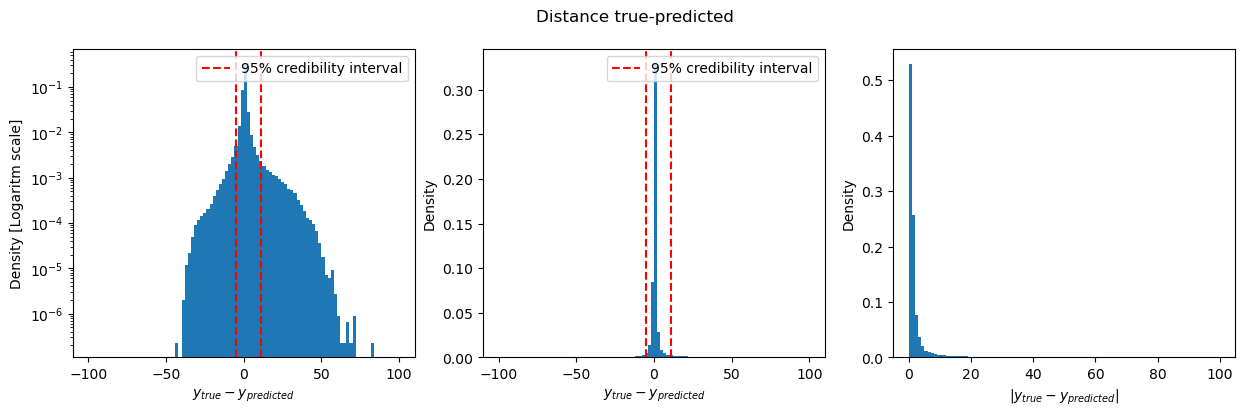

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

fig.suptitle('Distance true-predicted')
ax[0].hist(-Y_test+Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins));
ax[0].axvline(lower,  label='95% credibility interval', color='red', linestyle='--');
ax[0].axvline(x=upper, color='red', linestyle='--');
ax[0].set_ylabel('Density [Logaritm scale]')
ax[0].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[0].legend()

ax[1].hist(-Y_test+Y_predicted, bins=n_bins, density=True, range=(-n_bins, n_bins));
ax[1].axvline(x=lower, label='95% credibility interval', color='red', linestyle='--');
ax[1].axvline(x=upper, color='red', linestyle='--');
ax[1].set_ylabel('Density')
ax[1].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[1].legend()

ax[2].hist(np.abs(-Y_test+Y_predicted), bins=n_bins, density=True, range=(0, n_bins));
ax[2].set_ylabel('Density')
ax[2].set_xlabel(r'$|y_{true}-y_{predicted}|$')

/tmp/ipykernel_6241/3729988123.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


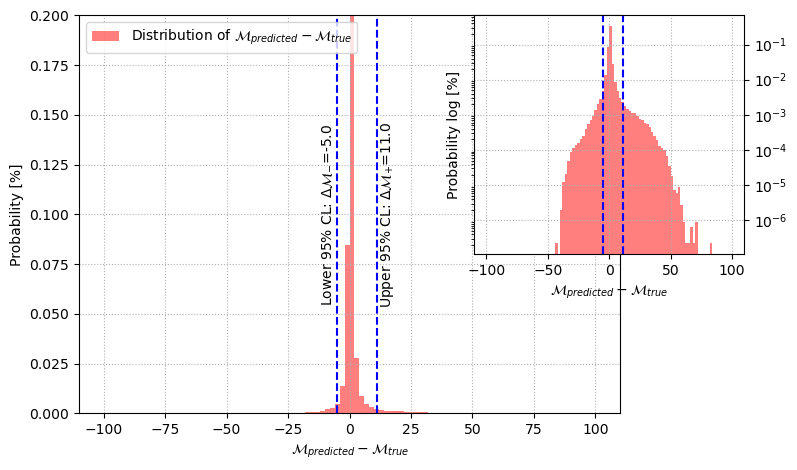

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.73, .4, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params(left=False, right=True, labelleft=False, labelright=True)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')
axins.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
           color='red', linewidth=1.7, log=True, histtype='stepfilled', alpha=0.5)
ax.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
         alpha=0.5, color='red', label=r'Distribution of $\mathcal{M} _{predicted}-\mathcal{M}_{true}$')
ax.legend(loc=2)
ax.set_ylabel("Probability [%]")
axins.set_ylabel("Probability log [%]")
ax.set_xlabel(r'$\mathcal{M}_{predicted}-\mathcal{M}_{true}$')
axins.set_xlabel(r'$\mathcal{M}_{predicted}-\mathcal{M}_{true}$')
ax.set_ylim(0,0.2)

ax.axvline(x=lower, label='95% credibility interval', color='blue', linestyle='--');
ax.axvline(x=upper, color='blue', linestyle='--');

axins.axvline(x=lower, label='95% credibility interval', color='blue', linestyle='--');
axins.axvline(x=upper, color='blue', linestyle='--');
ax.text(lower-7,0.1, r'Lower 95% CL: $\Delta \mathcal{M}_{-}$='+str(lower), rotation=90, va='center')
ax.text(upper+1,0.1, r'Upper 95% CL: $\Delta \mathcal{M}_{+}$='+str(upper), rotation=90, va='center')
plt.tight_layout()
plt.savefig('../Figures/lcp/hist_delta_Chirp_Mass_yeskicks.png', bbox_inches='tight')
plt.show()

## Misura della accuracy

In [26]:
threshold = 5

In [27]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [28]:
accuracy_threshold(Y_test, Y_predicted, 5)

0.9195250244660336

In [29]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [30]:
accuracy_exponential(Y_test, Y_predicted, 6)

0.9066372164450203

## Grid Search with For Loops

## Clustering of probability distribution

In [31]:
# Defininf a function to order the peaks of the probability distribution
def extract_top_values(row, n_top=3):
    row_sorted = np.sort(row)[::-1]
    return row_sorted[:n_top]

In [32]:
# Defininf a function to order the peaks of the probability distribution
def extract_id_top_values(row, n_top=3):
    idx_sorted = np.argsort(row)[::-1]
    return np.array(idx_sorted)[:n_top]

In [33]:
# applying the previous function
top_values = output_test.apply(extract_top_values, axis=1, meta=(None, 'object'))
idx_top_values = output_test.apply(extract_id_top_values, axis=1, meta=(None, 'object'))

## Creating a dataframe with all the test set information

In [34]:
top_values = top_values.compute()
top_values = pd.DataFrame(top_values.to_list(), columns = ['1', '2', '3'])

idx_top_values = idx_top_values.compute()
idx_top_values = pd.DataFrame(idx_top_values.to_list(), columns = ['1', '2', '3'])

for col in idx_top_values.columns:
    top_values[f'idx_{col}']=idx_top_values[col].values   
    
top_values['Y_predicted']=Y_predicted
top_values['Y_test']=Y_test
top_values['Delta_Y']=np.abs(Y_predicted-Y_test)

#adding feature
X_test = features_test.compute()
for col in X_test.columns:
    top_values[col]=X_test[col].values

In [35]:
top_values

,1,2,3,idx_1,idx_2,idx_3,Y_predicted,Y_test,Delta_Y,Mass_0,Z_0,Mass_1,a,e,alpha
0,0.145831,0.083930,0.047858,61,60,58,61,61.0,0.0,117.304,0.0004,83.859,490.0,0.01200,1.0
1,0.042210,0.041055,0.040466,60,64,62,60,60.0,0.0,103.967,0.0004,94.651,46600.0,0.10200,1.0
2,0.132043,0.050427,0.045423,27,29,44,27,24.0,3.0,57.596,0.0004,30.071,492.0,0.72200,1.0
3,0.035452,0.024184,0.020995,50,49,52,50,45.0,5.0,41.970,0.0004,39.797,149.0,0.04660,1.0
4,0.531732,0.027813,0.021814,68,70,69,68,68.0,0.0,64.356,0.0004,46.568,5080.0,0.01260,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257206,0.197406,0.152311,0.151846,7,9,6,7,7.0,0.0,41.591,0.0100,33.102,288.0,0.10100,3.0
2257207,0.942128,0.003656,0.003474,1,0,3,1,1.0,0.0,28.852,0.0100,25.141,274.0,0.13200,3.0
2257208,0.216129,0.061612,0.058839,35,32,31,35,34.0,1.0,84.835,0.0100,53.354,1060.0,0.00132,3.0
2257209,0.208499,0.072302,0.068106,9,10,6,9,8.0,1.0,48.857,0.0100,30.760,587.0,0.39000,3.0


In [36]:
idx_diff = top_values['idx_1']-top_values['idx_2']

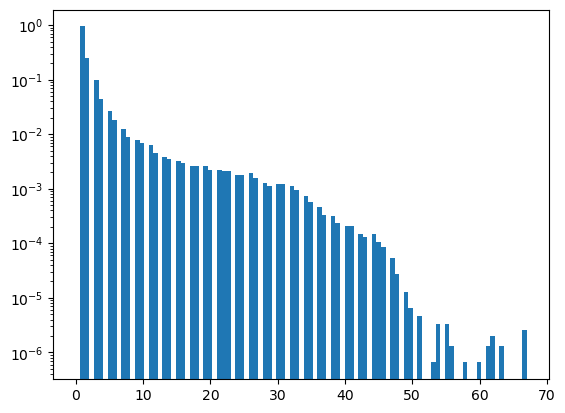

In [37]:
plt.hist(np.abs(idx_diff), bins=99, density=True, log=True, range=(0, idx_diff.max()));

# Some interesting representations

## All the points

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


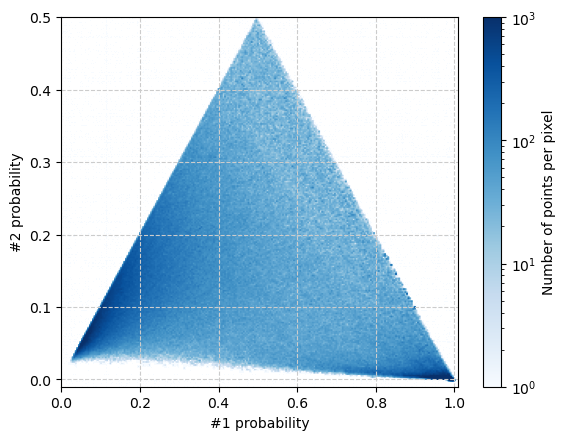

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values['1'], top_values['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/tops_Chirp_Mass_yeskicks.png', bbox_inches='tight')
plt.show()

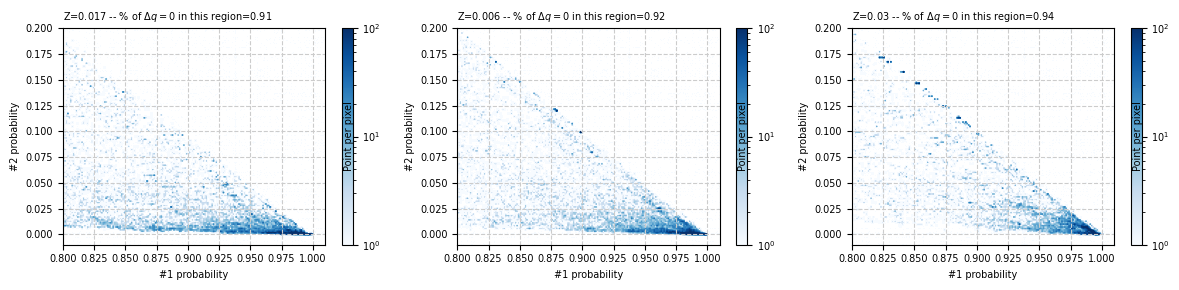

In [39]:
fontsize=7
fig = plt.figure(figsize=(12, 3))
Z=np.unique(top_values.Z_0)
Z=[0.017, 0.006, 0.03]

for i, z in enumerate(Z):
    ax = fig.add_subplot(1, 3, i+1, projection='scatter_density',)
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['2'],
                       cmap='Blues',
                       norm=colors.LogNorm(vmin=1, vmax=100), )
    ax.set_xlabel('#1 probability', fontsize=fontsize,)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('#2 probability', fontsize=fontsize)
    ax.set_xlim(0.8,1.01)
    ax.set_ylim(-0.01,0.2)
    ax.grid(linestyle='dashed', color=(0.8,0.8,0.8,0.2))
    
    # if i==2:
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.get_yaxis().labelpad = -26.5
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(rf'Z={z} -- % of $\Delta q=0$ in this region={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
plt.tight_layout()
plt.savefig('../Figures/lcp/zoom_peakregion_Chirp_Mass_yeskicks.png', bbox_inches='tight')

## Point correctly predicted

In [40]:
top_values_0 = top_values[top_values['Delta_Y']==0]

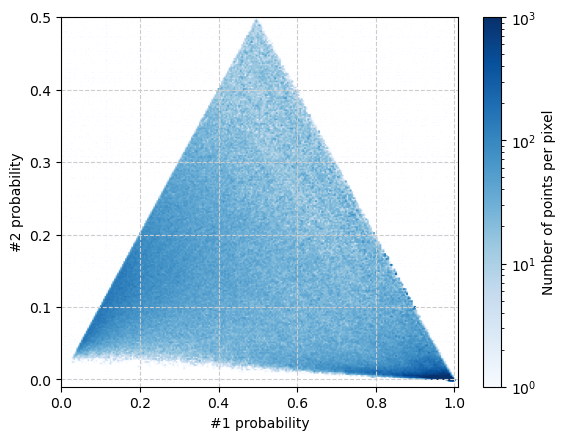

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['1'], top_values_0['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/tops_Mass_Chirp_perfect_yeskicks.png', bbox_inches='tight')
plt.show()

### Check for the Mass dependency

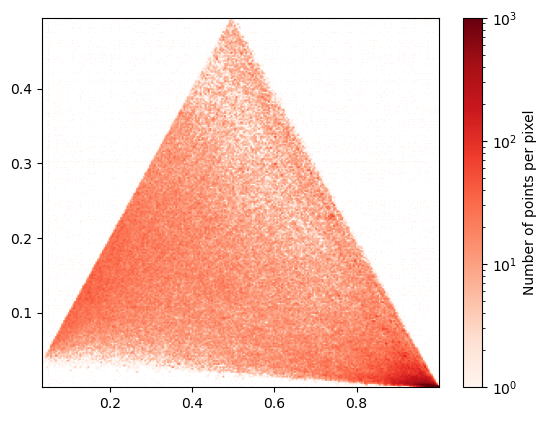

In [42]:
fig = plt.figure()
using_mpl_scatter_density(fig,
                          top_values_0[top_values_0['Mass_0']<40]['1'],
                          top_values_0[top_values_0['Mass_0']<40]['2'])
plt.show()

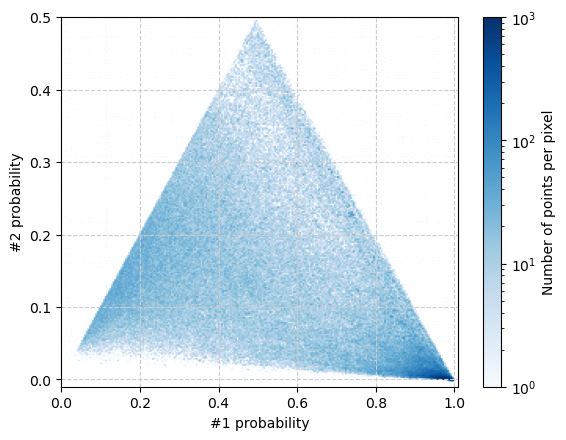

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0[top_values_0['Mass_0']<40]['1'], top_values_0[top_values_0['Mass_0']<40]['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/tops_Chirp_Mass_perfect_mass_less_40_yeskicks.png', bbox_inches='tight')
plt.show()

## Points with wrong prediction

In [44]:
top_values_15 = top_values[top_values['Delta_Y']>=threshold]

In [45]:
# sns.scatterplot(data = top_values_15, x= '1', y='2', hue='alpha', )


In [46]:
# fig = plt.figure()
# using_mpl_scatter_density(fig, top_values_15['1'], top_values_15['2'])
# plt.show()

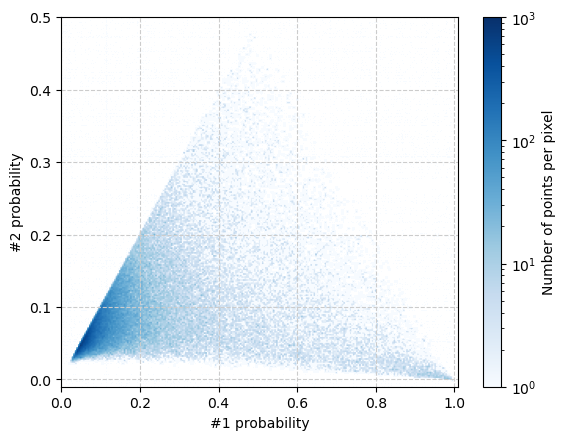

In [47]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['1'], top_values_15['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig(f'../Figures/lcp/tops_Chirp_Mass_error_more_{threshold}_yeskicks.png', bbox_inches='tight')
plt.show()

### Searching for dependences in other features

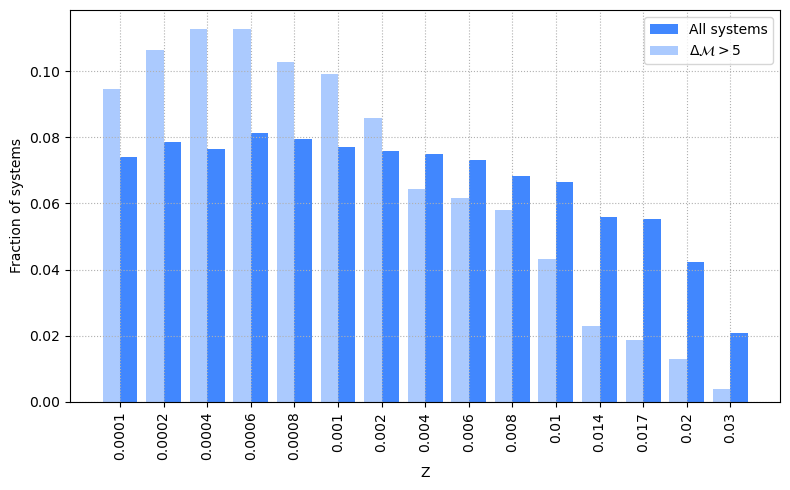

In [48]:
plt.figure(figsize=(8,5))
labels, counts_all = np.unique(top_values['Z_0'].values, return_counts=True)
X_axis = np.arange(len(labels))
plt.grid(linestyle='dotted')

plt.bar( X_axis+0.2, counts_all/counts_all.sum(),0.4,color=(65/255, 135/255, 254/255),label= 'All systems')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.xticks(X_axis, labels)

plt.bar( X_axis-0.2, counts/counts.sum(),0.4,color=(171/255, 202/255, 254/255), label=r'$\Delta \mathcal{M}>5$')
plt.xticks(rotation=90);
# plt.title('Metalliomparison');
plt.legend()
plt.xlabel('Z')
plt.ylabel('Fraction of systems')
plt.tight_layout()
plt.savefig('../Figures/lcp/z_comparison_Chirp_Mass_yeskicks.png', bbox_inches='tight')
plt.show()


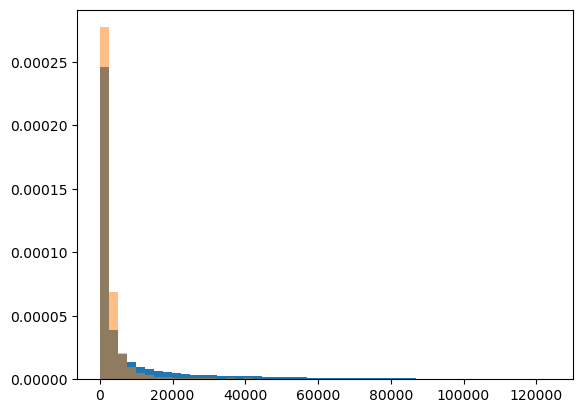

In [49]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values_15['a'], density=True, bins=50, alpha=0.5);

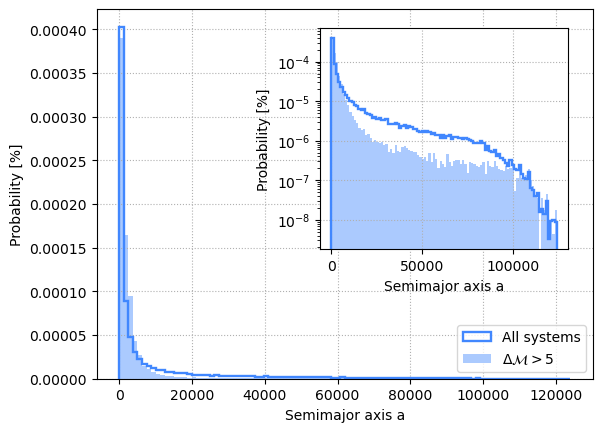

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['a'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_15['a'], bins=n_bins, label=r'$\Delta \mathcal{M}>5}$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['a'], bins=n_bins,log=True, histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_15['a'], bins=n_bins, log=True, density=True, color=(171/255, 202/255, 254/255))

ax.legend(loc=4)

ax.set_ylabel("Probability [%]")
ax.set_xlabel('Semimajor axis a')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Semimajor axis a')

plt.savefig('../Figures/lcp/a_comparison_Mass_Chirp_yeskicks.png', bbox_inches='tight')
plt.show()


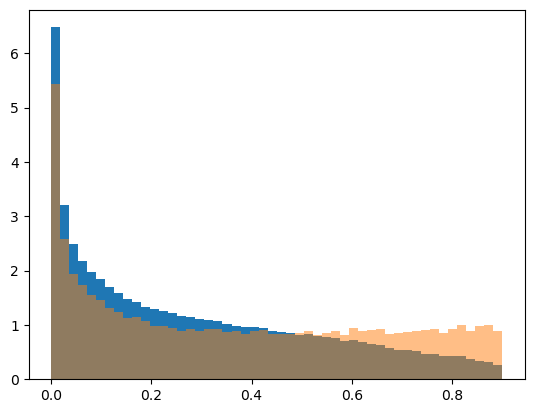

In [51]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values_15['e'], density=True, bins=50, alpha=0.5);

/tmp/ipykernel_6241/2013627032.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


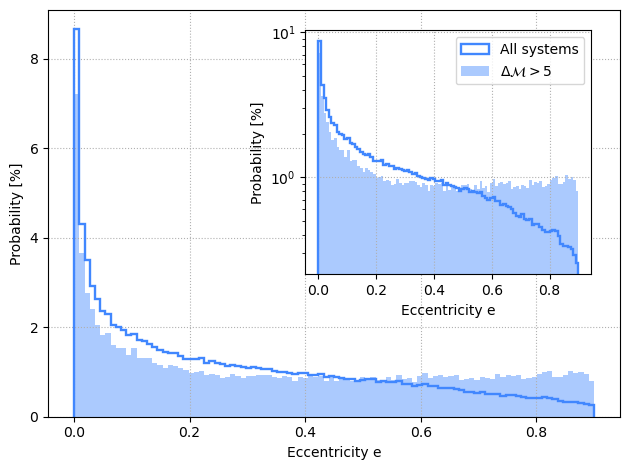

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.legend(loc=5)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['e'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_15['e'], bins=n_bins, label=r'$\Delta \mathcal{M}>5$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['e'], bins=n_bins,log=True, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_15['e'], bins=n_bins, log=True, density=True,label=r'$\Delta \mathcal{M}>5$', color=(171/255, 202/255, 254/255))


ax.set_ylabel("Probability [%]")
ax.set_xlabel('Eccentricity e')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Eccentricity e')
l=axins.legend()
# l.set_zorder(10) 
plt.tight_layout()
plt.savefig('../Figures/lcp/e_comparison_Chirp_Mass_yeskicks.png', bbox_inches='tight')
plt.show()


# Mass distribution

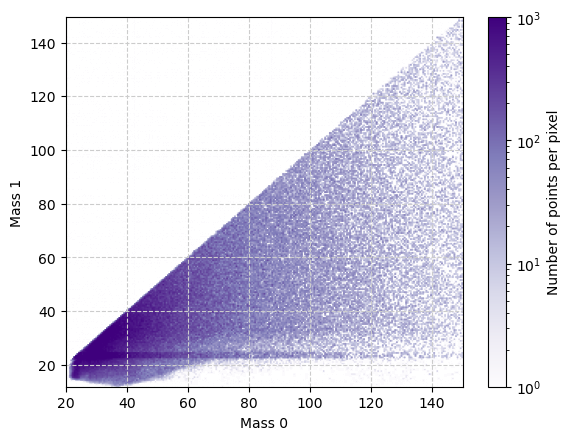

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values['Mass_0'], top_values['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

# plt.savefig('Figures/lcp/mass_0_mass_1.png')
plt.show()

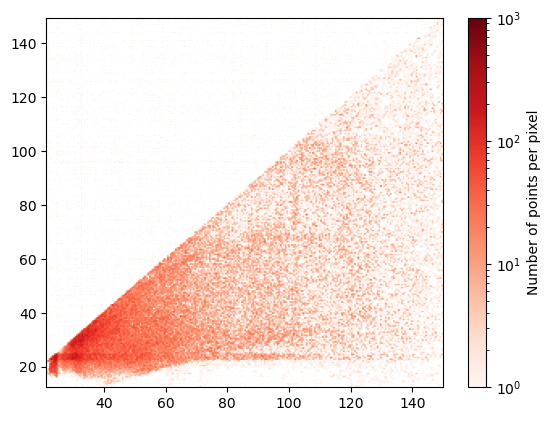

In [54]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['Mass_0'], top_values_15['Mass_1'])
plt.show()

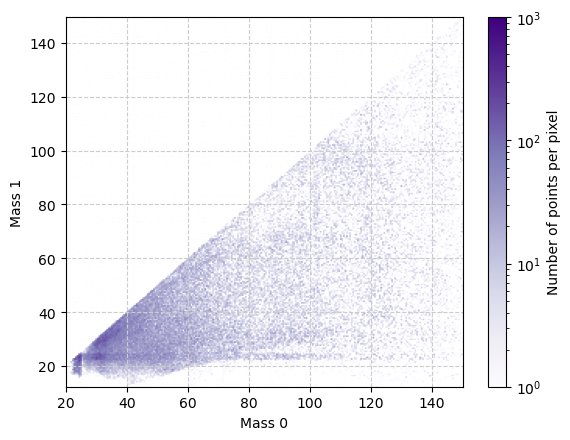

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['Mass_0'], top_values_15['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/mass_0_mass_1_error_5_Chirp_mass_yeskicks.png', bbox_inches='tight')
plt.show()

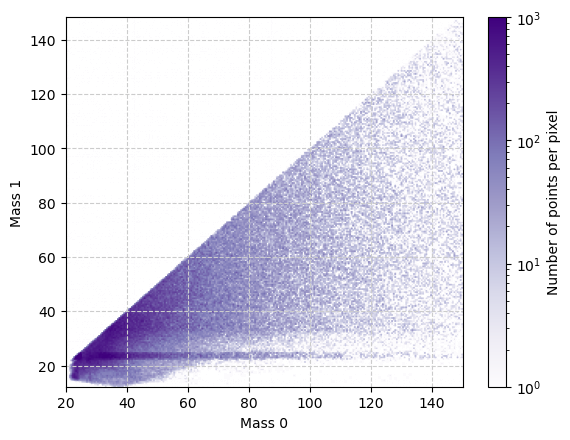

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['Mass_0'], top_values_0['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/mass_0_mass_1_all_right_Chirp_Mass_yeskicks.png', bbox_inches='tight')
plt.show()

## Attempt of 3D plot

## Some simple statistics

In [57]:
print(f'Fraction of data in the flat region: {len(top_values[top_values["1"]<0.2])/len(top_values):.2f}')

print(f'Fraction of exactly guessed labels: {len(top_values_0)/len(top_values):.2f}')

print( f"Exactly guessed label in flat region / total points in flat region:{  len(top_values_0[top_values_0['1']<0.2])/len(top_values[top_values['1']<0.2])  :.2f}"   )

print( f"Exactly guessed label in flat region / total exactly labels:{  len(  top_values_0[ top_values_0[ '1' ]<0.2 ] )/len(top_values_0)  :.2f}"   )



# len(top_values[top_values['1']<0.2])/len(top_values)

Fraction of data in the flat region: 0.25
Fraction of exactly guessed labels: 0.53
Exactly guessed label in flat region / total points in flat region:0.24
Exactly guessed label in flat region / total exactly labels:0.11


# Clustering by eye

# Plot of cluster

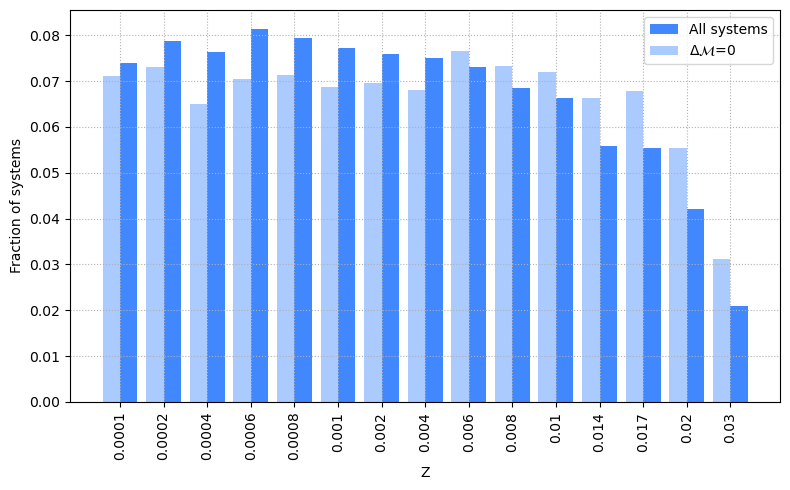

In [58]:
plt.figure(figsize=(8,5))
labels, counts_all = np.unique(top_values['Z_0'].values, return_counts=True)
X_axis = np.arange(len(labels))
plt.grid(linestyle='dotted')

plt.bar( X_axis+0.2, counts_all/counts_all.sum(),0.4,color=(65/255, 135/255, 254/255),label= 'All systems')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_0['Z_0'].values, return_counts=True)
plt.xticks(X_axis, labels)

plt.bar( X_axis-0.2, counts/counts.sum(),0.4,color=(171/255, 202/255, 254/255), label=r'$\Delta \mathcal{M}$=0')
plt.xticks(rotation=90);
# plt.title('Metalliomparison');
plt.legend()
plt.xlabel('Z')
plt.ylabel('Fraction of systems')
plt.tight_layout()
plt.savefig('../Figures/lcp/z_comparison_Mass_Chirp_one_peak_yeskicks.png', bbox_inches='tight')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'Cluster_peak'

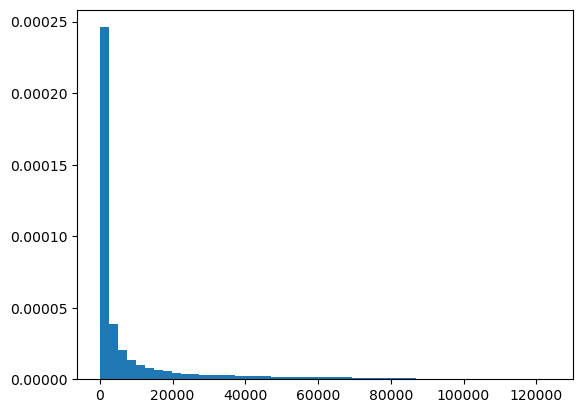

In [59]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values[top_values.Cluster_peak==1]['a'], density=True, bins=50, alpha=0.5);

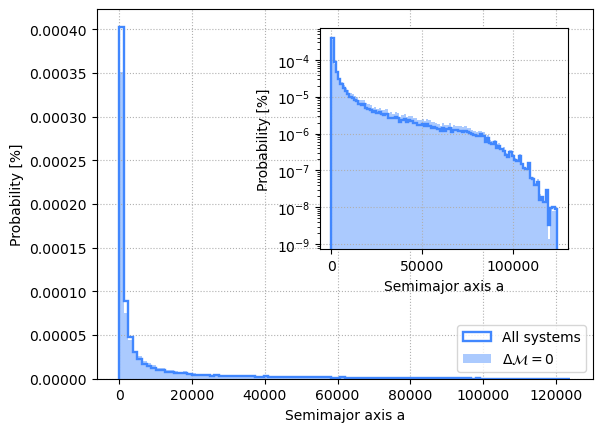

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['a'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_0['a'], bins=n_bins, label=r'$\Delta \mathcal{M}=0$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['a'], bins=n_bins,log=True, histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_0['a'], bins=n_bins, log=True, density=True, color=(171/255, 202/255, 254/255))

ax.legend(loc=4)

ax.set_ylabel("Probability [%]")
ax.set_xlabel('Semimajor axis a')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Semimajor axis a')

plt.savefig('../Figures/lcp/a_comparison_Mass_Chirp_one_peak_yeskicks.png', bbox_inches='tight')
plt.show()


In [ ]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values[top_values.Cluster_peak==1]['e'], density=True, bins=50, alpha=0.5);

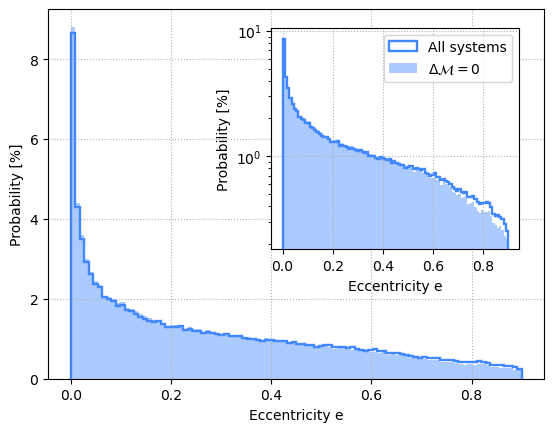

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.legend(loc=5)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['e'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_0['e'], bins=n_bins, label=r'$\Delta \mathcal{M}=0$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['e'], bins=n_bins,log=True, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_0['e'], bins=n_bins, log=True, density=True,label=r'$\Delta \mathcal{M}=0$', color=(171/255, 202/255, 254/255))


ax.set_ylabel("Probability [%]")
ax.set_xlabel('Eccentricity e')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Eccentricity e')
l=axins.legend()
# l.set_zorder(10) 
plt.savefig('../Figures/lcp/e_comparison_Mass_Chirp_one_peak_yeskicks.png', bbox_inches='tight')
plt.show()


In [ ]:
bhbh_test.columns

In [ ]:
bhbh_test[bhbh_test.Z_0==0.006].groupby("No_Kick").count().compute()

In [ ]:
cluster.close()